In [ ]:
! pip install pymysql

Install Python 3.9.13

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.feature_selection as fs
import pickle
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import normalize
from sklearn.svm import SVR, NuSVR
from sklearn.pipeline import make_pipeline

# Grab Dataset

In [ ]:
ysi = pd.read_csv("../datasets/ysi_dataset.csv")
weather = pd.read_csv("../datasets/weather_dataset.csv")
# convert to date time and round ysi to nearest 15 mins
ysi['datetime'] = pd.to_datetime(ysi['datetime']).dt.round('15min')
weather['datetime'] = pd.to_datetime(weather['datetime'])

In [ ]:
# combine both DF's on datetime
combined = pd.merge(ysi, weather, on='datetime')
combined.reset_index(drop=True, inplace=True)
combined = combined.drop(columns=['experimentid_y'])
combined.columns

# Data Visualization

In [ ]:
# combined = combined.drop(combined[combined['ph'] < 5].index)
# combined = combined.drop(combined[combined['ph'] > 9].index)
combined = combined.drop(combined[combined['dissolved_oxygen_mg_l'] < 2].index)
combined = combined.drop(combined[combined['dissolved_oxygen_mg_l'] > 20].index)
combined = combined.drop(combined[combined['dissolved_oxygen_mg_l'] < 3/100 * combined['global_light_energy_w_m2']].index)
combined = combined.drop(combined[combined['dissolved_oxygen_mg_l'] >( 3/100 * combined['global_light_energy_w_m2']) + 15].index)

In [ ]:
len(combined)

In [ ]:
feat = combined.sample(3000)
plt.plot(feat['temperature_oc'],feat['dissolved_oxygen_mg_l'], 'bo')
plt.ylabel("ph")
plt.xlabel("global_light_energy_w_m2")
plt.show()

# Feature Selection

In [ ]:
X = feat[['ph', 'temperature_oc', 'airtemp_oc','global_light_energy_w_m2', 'humid_rh']].values
y = feat['dissolved_oxygen_mg_l'].values
regressor = RandomForestRegressor(n_estimators=50)
regressor.fit(X, y)


print(regressor.feature_importances_)

model = SelectFromModel(regressor, prefit=True)
X_new = model.transform(X)

features selected: ph, temperature_oc, global_light_energy_w_m2, humid_rh
not considered: wdspd_m_s (low correlation), par_umol_photons_m2_s (duplicated),

# Training

In [ ]:
test = combined.copy(True)
X_train,X_test,y_train,y_test = train_test_split(test[['ph', 'temperature_oc', 'global_light_energy_w_m2', 'humid_rh', 'airtemp_oc']], 
        test['dissolved_oxygen_mg_l'], test_size=0.15)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math

def stats(y_pred_all, y_test_all):
    # Calculate the R2 score
    r2 = r2_score(y_test_all, y_pred_all)

    print(f"R2 Score: {r2:.4f}")
    # Calculate MAE
    mae = mean_absolute_error(y_test_all, y_pred_all)

    # Calculate RMSE
    mse = mean_squared_error(y_test_all, y_pred_all, squared=False)

    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", math.sqrt(mse))

In [47]:
print("------------ Exponential SVR Results ------------")
clf_rbf_nusvm = make_pipeline(preprocessing.SplineTransformer(), NuSVR(kernel='rbf', shrinking=True, C=1.5))
clf_rbf_nusvm.fit(X_train, y_train)
y_pred = clf_rbf_nusvm.predict(X_test)
stats(y_pred, y_test)

print("------------ Exponential SVR Results ------------")
clf_rbf_svm = make_pipeline(preprocessing.SplineTransformer(), SVR(kernel='rbf', shrinking=True, C=1.5))
clf_rbf_svm.fit(X_train[:len(X_train)//2], y_train[:len(X_train)//2])
clf_rbf_svm.fit(X_train[len(X_train)//2:], y_train[len(X_train)//2:])
y_pred = clf_rbf_svm.predict(X_test)
stats(y_pred, y_test)

print("------------ Polynomial SVR Results ------------")
clf_poly_nusvm = make_pipeline(preprocessing.SplineTransformer(), NuSVR(kernel='poly', shrinking=False, C=2.5))
clf_poly_nusvm.fit(X_train, y_train)
y_pred = clf_poly_nusvm.predict(X_test)
stats(y_pred, y_test)

------------ Exponential SVR Results ------------
R2 Score: 0.7887
Mean Absolute Error (MAE): 1.4127783341589235
Root Mean Squared Error (RMSE): 1.4020254814598059
------------ Exponential SVR Results ------------
R2 Score: 0.7779
Mean Absolute Error (MAE): 1.4072407884672102
Root Mean Squared Error (RMSE): 1.4195757980285841
------------ Polynomial SVR Results ------------
R2 Score: 0.7991
Mean Absolute Error (MAE): 1.3673856084330933
Root Mean Squared Error (RMSE): 1.3843152347820762


In [ ]:
print("------------ Bagging Results ------------")
from sklearn.ensemble import BaggingRegressor
model = make_pipeline(preprocessing.SplineTransformer(), BaggingRegressor(n_jobs=5))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
stats(y_pred, y_test)

'''
print("------------ Stacking Results ------------")
from sklearn.ensemble import StackingRegressor
model = StackingRegressor(estimators=[
    ('svr', NuSVR(kernel='poly', shrinking=False, C=2.5)), 
    ('rf', RandomForestRegressor(n_estimators=10,random_state=42, n_jobs=8)),
    ('bag', BaggingRegressor(n_jobs=5)),
    ('bst', GradientBoostingRegressor(learning_rate=0.1, loss='huber', max_depth=6, criterion='squared_error')),
    ('n1', MLPRegressor(hidden_layer_sizes=(2,3), activation='relu')),
    ('n2', MLPRegressor(hidden_layer_sizes=(3,2), activation='tanh'))
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
stats(y_pred, y_test) '''

In [ ]:
print("------------ Random Forest Results ------------")
rf_regressor = make_pipeline(preprocessing.SplineTransformer(), RandomForestRegressor(n_estimators=24, max_depth=20))
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)
stats(y_pred, y_test)

print("------------ Poly Regression Results ------------")
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_features = PolynomialFeatures(degree=5, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
# Initialize and fit the linear regression model
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
# Predict the target variable for training and test sets
y_pred = poly_reg.predict(X_test_poly)
stats(y_pred, y_test)

print("------------ Decision Tree Results ------------")
from sklearn.tree import DecisionTreeRegressor
d_tree = DecisionTreeRegressor(max_depth=24)
d_tree.fit(X_train, y_train)
y_pred = d_tree.predict(X_test)
stats(y_pred, y_test)

print("------------ XG Boost Results ------------")
from sklearn.ensemble import GradientBoostingRegressor
xg_boost = GradientBoostingRegressor(learning_rate=0.1, loss='huber', max_depth=6, criterion='squared_error')
xg_boost.fit(X_train, y_train)
y_pred = xg_boost.predict(X_test)
stats(y_pred, y_test)

In [ ]:
model = nn.Sequential(
    nn.Linear(3, 16),
    nn.CELU(),
    nn.Linear(16, 16),
    nn.CELU(),
    nn.Linear(16, 4),
    nn.CELU(),
    nn.Linear(4, 1)
)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, dataframe):
        self.numeric_columns = ['ph', 'temperature_oc', 'global_light_energy_w_m2']
        self.quantile_transformer = preprocessing.PowerTransformer()
        transformed_data = self.quantile_transformer.fit_transform(dataframe[self.numeric_columns].values)
        dataframe[self.numeric_columns] = transformed_data
        self.data = dataframe.dropna(subset=['dissolved_oxygen_mg_l']).reset_index(drop=True)

    def __len__(self):
        return len(self.data)
    
    def getInverseTransform(self, inputs):
        return self.quantile_transformer.inverse_transform(inputs)

    def __getitem__(self, idx):
        inputs = self.data[self.numeric_columns].iloc[idx].values.astype(np.float32)
        label = self.data['dissolved_oxygen_mg_l'].iloc[idx].astype(np.float32)
        inputs = torch.tensor(inputs)
        label = torch.tensor(label)
        return inputs, label


In [ ]:
loss_fn = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.01)
num_epochs = 20

test = combined.copy(True)
trainset, testset = train_test_split(test, test_size=0.3)

dataset = MyDataset(trainset)
data_loader = DataLoader(dataset, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(data_loader)
    # Print the loss for each epoch
    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss:.4f}")
# Training complete

In [ ]:
# save weights
torch.save(model.state_dict(), './weights/weights2.sav')
model.load_state_dict(torch.load('./weights/weights2.sav'))

# weights 1 : loss = 30.98
# weights 2 : loss = 1.1218

# Evaluation

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math

# Set the model to evaluation mode
model.eval()

# Initialize lists to store true and predicted values
y_test_all = []
y_pred_all = []

newset = pd.merge(ysi, weather, on='datetime').sample(1000)

dataset = MyDataset(testset)
data_loader = DataLoader(dataset)

# Disable gradient calculation
with torch.no_grad():
    for inputs, label in data_loader:

        # Forward pass to get predictions
        y_pred = model(inputs)

        # Convert the predictions and targets to numpy arrays
        y_pred_np = y_pred.numpy()
        label_np = label.numpy()
        #print(dataset.quantile_transformer.inverse_transform(inputs.numpy()))
        #print(f"actual: { y_pred.item():3f} predicted: {label.item():3f}")

        # Append batch results to the overall lists
        y_test_all.append(label_np)
        y_pred_all.append(y_pred_np)

# Concatenate the lists into a single array
y_test_all = np.concatenate(y_test_all)
y_pred_all = np.concatenate(y_pred_all)

# Calculate the R2 score
r2 = r2_score(y_test_all, y_pred_all)

print(f"R2 Score: {r2:.4f}")
# Calculate MAE
mae = mean_absolute_error(y_test_all, y_pred_all)

# Calculate RMSE
mse = mean_squared_error(y_test_all, y_pred_all, squared=False)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", math.sqrt(mse))

# Pre - Trained Models

In [ ]:
play = nn.Sequential(
    nn.Linear(4, 8),
    nn.LeakyReLU(),
    nn.Linear(8, 8),
    nn.LeakyReLU(),
    nn.Linear(8, 1)
)

play.load_state_dict(torch.load('weights.sav'))

# Save Weights

In [ ]:
model

In [ ]:
import tarfile
import json
import io

# Save the trained model
model_filename = './weights/do_rf.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

# Load the saved model
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Specify the name of the pickle file and the .mar archive file
mar_filename = 'model_archive.mar'

# Create a new tar archive
with tarfile.open(mar_filename, 'w') as archive:
    # Add the pickle file to the archive
    archive.add(model_filename)

# Create a manifest file with the required metadata
manifest = {'model-file': model_filename, 'model-name': 'RandomForestRegressor'}

# Add the manifest file to the archive
with tarfile.open(mar_filename, 'a') as archive:
    manifest_string = json.dumps(manifest)
    manifest_bytes = manifest_string.encode('utf-8')
    manifest_file = tarfile.TarInfo('MANIFEST')
    manifest_file.size = len(manifest_bytes)
    archive.addfile(manifest_file, io.BytesIO(manifest_bytes))


# Check performance on DB values

In [28]:
import pymysql

# Connect to the database
connection = pymysql.connect(
    host='localhost', 
    user='root', 
    password='N@wid2003', 
    db='dma_iot_morefish_spark_farms_v3'
)

# Create a cursor object
cursor = connection.cursor()

# Get the latest data from the database and store it in a pandas dataframe
query = "SELECT dvd_ph, dvd_temp, dvd_updated_at FROM device_devicedata WHERE dvd_ph > 0 AND dvd_temp > 0 AND dvd_dev_id = 2 ORDER BY dvd_updated_at ASC"
df = pd.read_sql(query, connection)

# Close the connection
connection.close()
len(df)

/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


778

In [29]:
df.rename(columns={'dvd_ph': 'ph', 'dvd_temp': 'temperature', 'dvd_updated_at': 'datetime'}, inplace=True)
df['rounded_datetime'] = pd.to_datetime(df['datetime']).dt.round('H')
spark_weather = pd.read_csv("../../../../../../Downloads/sparkfarmsweather.csv")
spark_weather['time'] = pd.to_datetime(spark_weather['time'])
spark_weather.rename(columns={'time': 'datetime'}, inplace=True)
# Merge the weather data with the main DataFrame based on 'rounded_datetime' column
df = df.merge(spark_weather[['datetime', 'diffuse_radiation (W/m²)', 'relativehumidity_2m (%)', 'temperature_2m (°C)']], left_on='rounded_datetime', right_on='datetime', how='left')
df = df.drop(columns=['datetime_y'])
df.rename(columns={'datetime_x': 'datetime', 'diffuse_radiation (W/m²)': 'light', 'relativehumidity_2m (%)': 'humid', 'temperature_2m (°C)': 'airtemp' }, inplace=True)
# drop all NaN values inside diffuse radiation
df = df.dropna(subset=['light'])

387


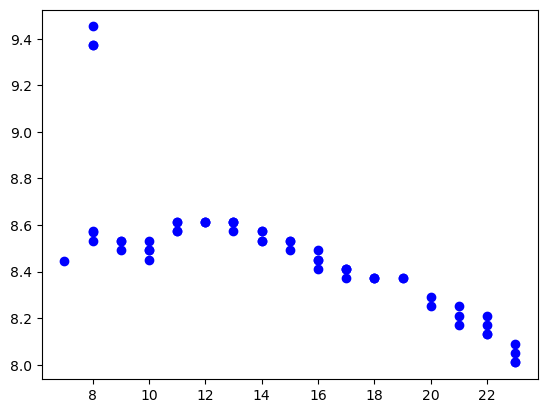

In [46]:
#df = df[df['diffuse_radiation (W/m²)_x'].notna()]
print(len(df))
bet = df.loc[df['datetime'].between('2023-06-08', '2023-06-09')]
plt.plot(bet['datetime'].dt.hour, bet['ph'].astype(float), 'bo')
plt.show()

In [48]:
x_train = df[['ph', 'temperature', 'light', 'humid', 'airtemp']].values
y_pred = clf_rbf_nusvm.predict(x_train)
df['Bagging'] = y_pred


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SplineTransformer was fitted with feature names
  warnings.warn(


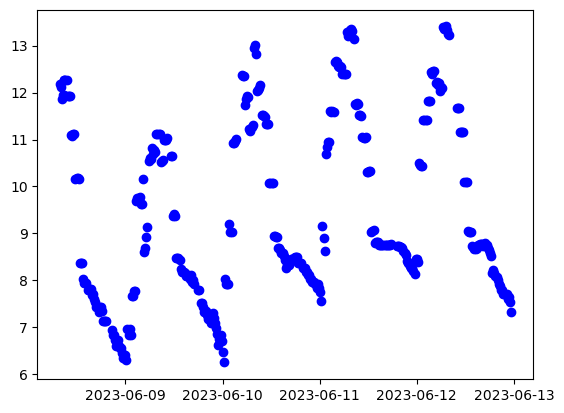

In [49]:
plt.plot(df['datetime'], df['Bagging'], 'bo')
plt.show()

In [ ]:
df.head(20)